In [50]:
import warnings
#warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os


Set some matplotlib configs for visualization

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

# Import data

In [5]:
data_dir = "./data"
tripadvisor_df = pd.read_csv(os.path.join( data_dir, 'tripadvisor_hotel_reviews.csv.zip'))
print(" tripadvisor_df shape: ", tripadvisor_df.shape)
tripadvisor_df.head()

 tripadvisor_df shape:  (20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [35]:
all_reviews  = tripadvisor_df['Review'].values
print(all_reviews[1])

ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman bus

# Clean review texts

In [36]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
# downloading nltk data
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SES100\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [37]:
def clean_review(raw_review: str) -> str:
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", raw_review)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    resutl = ' '.join(lemmas)
    # and return the result.
    return resutl

In [38]:
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

In [39]:
print(all_reviews[1])

ok nothing special charge diamond member hilton decide chain shoot th anniversary seattle start book suite pay extra website description suite bedroom bathroom standard hotel room take print reservation desk show say thing like tv couch ect desk clerk tell oh mix suite description kimpton website sorry free breakfast get kid embassy suit sit room bathroom bedroom unlike kimpton call suite day stay offer correct false advertise send kimpton prefer guest website email ask failure provide suite advertise website reservation description furnish hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concern guest staff range indifferent helpful ask desk good breakfast spot neighborhood hood tell hotel gee best breakfast spot seattle block away convenient hotel doe know exist arrive late night pm inside run bellman busy chat cell phone help bag prior arrival email hotel inform th anniversary half really picky want mak

In [41]:
#from gensim.models import KeyedVectors
import gensim
from gensim.parsing.preprocessing import remove_stopwords
#from keras.utils import to_categorical

def prepare_text(texts):
    final_text = []
    for txt in texts:
        text = remove_stopwords(txt)
        text_tokenised = gensim.utils.simple_preprocess(text) # does some simple toxenisation
        final_text.append(text_tokenised)
    return final_text
        
reviews = prepare_text(all_reviews)

for i in range(10):
    print(f"{i} review: {reviews[i][0:8]}")

0 review: ['nice', 'hotel', 'expensive', 'park', 'good', 'deal', 'stay', 'hotel']
1 review: ['ok', 'special', 'charge', 'diamond', 'member', 'hilton', 'decide', 'chain']
2 review: ['nice', 'room', 'experience', 'hotel', 'monaco', 'seattle', 'good', 'hotel']
3 review: ['unique', 'great', 'stay', 'wonderful', 'time', 'hotel', 'monaco', 'location']
4 review: ['great', 'stay', 'great', 'stay', 'seahawk', 'game', 'awesome', 'downfall']
5 review: ['love', 'monaco', 'staff', 'husband', 'stay', 'hotel', 'crazy', 'weekend']
6 review: ['cozy', 'stay', 'rainy', 'city', 'husband', 'spend', 'night', 'monaco']
7 review: ['excellent', 'staff', 'housekeep', 'quality', 'hotel', 'chock', 'staff', 'feel']
8 review: ['hotel', 'stay', 'hotel', 'monaco', 'cruise', 'room', 'generous', 'decorate']
9 review: ['excellent', 'stay', 'hotel', 'monaco', 'past', 'delight', 'reception', 'staff']


# Check the lenght of reviews

In [48]:
from scipy import stats

review_lenght = np.array(list(map(len, reviews)))
median = np.median(review_lenght)
mean = np.mean(review_lenght)
mode = stats.mode(review_lenght)[0][0]

print(f'median: {median}, mean: {mean}, mode:{mode}')

median: 70.0, mean: 94.19320677370553, mode:56


c:\Users\SES100\Anaconda3\envs\roni\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


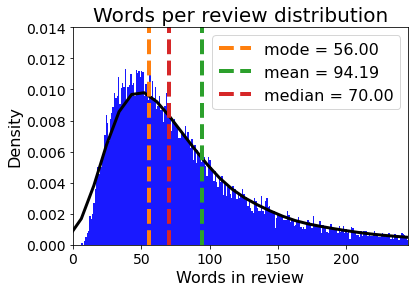

In [51]:
fig, ax = plt.subplots()
sb.distplot(review_lenght, bins=review_lenght.max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(review_lenght, 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()